In [13]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import pandas as pd
%matplotlib inline  

In [14]:
# Load data
X_train = np.load("../Data/numpy/matlab.mat_x_train.npy")
X_test = np.load("../Data/numpy/matlab.mat_x_test.npy")
Y_train = np.load("../Data/numpy/matlab.mat_y_train.npy")
Y_test = np.load("../Data/numpy/matlab.mat_y_test.npy")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Setup data for Torch use
tensor_x = torch.Tensor(X_train)
tensor_y = torch.Tensor(Y_train).type(torch.LongTensor)
train_data = TensorDataset(tensor_x,tensor_y)
train_loader = DataLoader(train_data)

tensor_x = torch.Tensor(X_test)
tensor_y = torch.Tensor(Y_test).type(torch.LongTensor)
test_data = TensorDataset(tensor_x,tensor_y)
test_loader = DataLoader(test_data)

In [15]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(10000, 50)
        self.linear2 = torch.nn.Linear(50, 20)
        self.dropout = torch.nn.Dropout(p=0.2)
        self.linear3 = torch.nn.Linear(20, 9)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

In [16]:
y_loss = {"train": [], "test": []}
y_acc = {"train": [], "test": []}

model = Model()
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    running_loss = 0
    correct = 0
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item() * len(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_loss["train"].append(running_loss / num_batches)
    y_acc["train"].append(correct / num_batches)



def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    y_loss["test"].append(test_loss)
    y_acc["test"].append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
learning_rate = 1e-3
# batch_size = 32
epochs = 10

y_loss["train"] = []
y_loss["test"] = []
y_acc["train"] = []
y_acc["test"] = []

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, t)
    test_loop(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 91.3%, Avg loss: 0.886974 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.416491 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.322292 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.252235 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.234647 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.230376 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.204309 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.167016 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.176211 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.160787 

Done!


[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy'), Text(0.5, 1.0, 'Accuracy')]

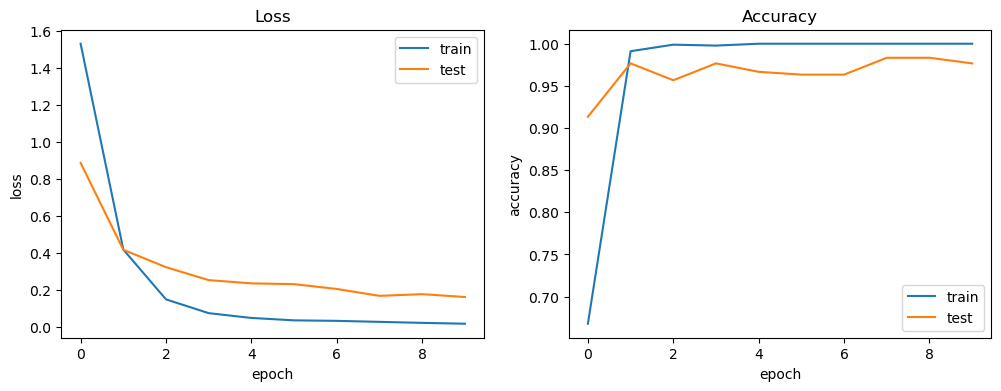

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
# # ax0 = fig.add_subplot(121, title="loss")
# ax1 = fig.add_subplot(122, title="top1err")
# ax[0].
ax0.plot(y_loss["train"], label="train")
ax0.plot(y_loss["test"], label="test")
ax0.legend()
ax0.set(xlabel="epoch", ylabel="loss", title="Loss")

ax1.plot(y_acc["train"], label="train")
ax1.plot(y_acc["test"], label="test")
ax1.legend()
ax1.set(xlabel="epoch", ylabel="accuracy", title="Accuracy")
